In [88]:
import json
import collections
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
import pandas as pd
import nltk
from sklearn import preprocessing
import time
from datetime import datetime
from datetime import timedelta

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [89]:
def release_base_dat():
    with open('data/processed_trumptwitterarchive.txt', 'r') as data_file:
        json_data = data_file.read()

    data = json.loads(json_data)

    times = [d['created_at'] for d in data]
    favorite_count = [d['favorite_count'] for d in data]
    retweet_count = [d['retweet_count'] for d in data]
    texts = [" ".join(d['processed_text']) for d in data]
    baseline_dat = pd.DataFrame({'created_time': pd.to_datetime(times),
#                                 'favorite_count': favorite_count, 
#                                'retweet_count': retweet_count, 
                                'texts': texts})  # not including favorite_count and retweet_count

    top_20_words = ["china", "billion", "products", "democrats", "great","dollars","tariffs","country", "mueller","border",\
                     "president", "congressman", "people", "korea", "party", "years", "farmers", "going", "trade", "never"]

    for word in top_20_words:
        baseline_dat[word] = baseline_dat['texts'].apply(lambda x: 1 if word in x else 0)

    display(baseline_dat.head())
    baseline_dat.to_csv('data/baseline_data_no_count.csv', index = False)

In [90]:
def merge_data(baseline_dir = 'data/baseline_data_no_count.csv', 
               senti_dir = 'data/sentimentAnalysis/senti.csv', 
               spx_dir = 'data/all_cleaned_SPX_data.csv', 
               m = 5):
    
    df1= pd.read_csv(baseline_dir)
    senti_data = pd.read_csv(senti_dir)
    df2 = senti_data[['time', 'positive_count', 'negative_count']]
    df = pd.merge(df1, df2, left_on = 'created_time', right_on='time').drop(['time'], axis=1)
    
    df['created_time'] = df['created_time'].apply(lambda x: pd.to_datetime(x))
    df['begin_time'] = df['created_time'].dt.floor('1min')
    df['end_time'] = df['begin_time'] + timedelta(minutes=m)
    
    data_econ = pd.read_csv('data/all_cleaned_SPX_data.csv')
    data_econ['datetime'] = pd.to_datetime(data_econ['datetime'], utc = True)
    df_econ = data_econ[['datetime', 'close']]
    
    df_merge1 = pd.merge(df, df_econ, left_on = 'begin_time', right_on='datetime').drop(['datetime'], axis=1)
    df_merge2 = pd.merge(df_merge1, df_econ, left_on = 'end_time', right_on='datetime').drop(['datetime'], axis=1)
    
    df_merge2['returns'] = df_merge2['close_y']/df_merge2['close_x']-1
    
    df_all = df_merge2.drop(['created_time','begin_time','end_time', 'close_x','close_y', 'texts'], axis=1)
    
    return df_all
    

In [91]:
def regression_models(df_all):
    df_all = df_all.copy()
    X_train, X_test, y_train, y_test =train_test_split(df_all.loc[:, df_all.columns != 'returns'], 
                                                         df_all.returns, test_size=0.2)
    
    scores = {}
    min_max_scaler = MinMaxScaler().fit(X_train)
    xtrain_scaled = min_max_scaler.transform(X_train.values)
    xtest_scaled = min_max_scaler.transform(X_test.values)
    X_train_scaled = pd.DataFrame(xtrain_scaled, columns = X_train.columns, index = X_train.index)
    X_test_scaled = pd.DataFrame(xtest_scaled, columns = X_test.columns, index = X_test.index)
    
    # Linear Regression
    Linear_model = LinearRegression()
    Linear_model.fit(X_train_scaled, y_train)
 
    # Lasso cv
    CV_lasso = LassoCV(cv = 3, max_iter = 10000)
    CV_lasso.fit(X_train_scaled, y_train)
    
    # randomforest
    rf = RandomForestRegressor(n_estimators = 10)
    rf.fit(X_train_scaled,y_train)
    
    models = [Linear_model, CV_lasso, rf]
    names = ['Linear Regression', "Lasso CV", "randomforest"]
    
    for name, model in zip(names, models):
        scores[name] = [mean_squared_error(model.predict(X_train_scaled), y_train), mean_squared_error(model.predict(X_test_scaled), y_test)]
    
    return scores


In [92]:
regression_models(merge_data())

{'Linear Regression': [4.198582261887819e-07, 4.3457386308789533e-07],
 'Lasso CV': [4.2131317210235866e-07, 4.345085161285479e-07],
 'randomforest': [3.7696402729512386e-07, 4.6026561695154576e-07]}

In [93]:
def combined(m, times = 5):
    df_all = merge_data(m = m)
    
    import collections
    names = ['Linear Regression', "Lasso CV", "randomforest"]
    scores = collections.defaultdict(list)
    for i in range(times):
        temp = regression_models(df_all)
        for n in names:
            scores[n].append(temp[n][1]) # only test score
            
    for n in names:
        scores[n] = np.mean(scores[n])
    return scores

In [94]:
from tqdm import tqdm
scores = {}
ms = range(1, 60, 3)
for m in tqdm(ms):
    scores[m] = combined(m) 


100%|██████████| 20/20 [01:18<00:00,  3.96s/it]

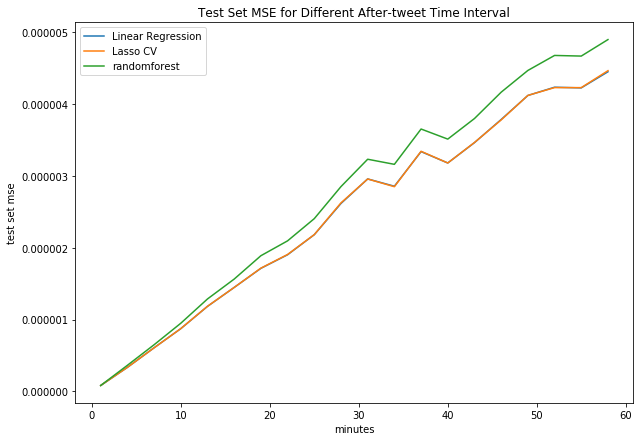

In [96]:
fig, ax = plt.subplots(1,1,figsize = (10,7))
names = ['Linear Regression', "Lasso CV", "randomforest"]
for n in names:
    test_scores = [score[n] for score in scores.values()]
    ax.plot(ms, test_scores, label = n)
    ax.set_xlabel('minutes')
    ax.set_ylabel('test set mse')
    ax.set_title('Test Set MSE for Different After-tweet Time Interval')
ax.legend()

In [99]:
fig.savefig('test_set_mse.png', dpi=1200)